Complete Generator Adversarial Network which I typed

Activate this when running in Google Colab

In [1]:
from google.colab import drive
import os

# Mounting Google Drive
drive.mount('/drive', force_remount=True)
os.chdir('/drive/My Drive/Colab/GenerativeAdversarialNetworks/Chapter02')

# Load the TensorBoard notebook extension
%load_ext tensorboard

# # Download Dataset
# !wget http://3dshapenets.cs.princeton.edu/3DShapeNetsCode.zip
# !mv 3DShapeNetsCode.zip data/
# !unzip ./data/3DShapeNetsCode.zip -d ./data

# Clear any logs from previous runs
# !rm -rf ./logs/ 

# See if you can access all the needed data
# !ls ./data/3DShapeNets/volumetric_data/stool/30/train/


Mounted at /drive


In [2]:
import glob
import time

import numpy as np
import scipy.io as io
import scipy.ndimage as nd
import tensorflow as tf
from keras import Sequential
from keras.callbacks import TensorBoard
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv3D, Deconv3D
from keras.layers.core import Activation
from keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt

# Fixed problems with Error #15: Initializing libiomp5md.dll, but found libiomp5 already initialized.
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Function to clear the screen

In [3]:
def clear():
  
    # for windows
    if os.name == 'nt':
        _ = os.system('cls')
  
    # for mac and linux(here, os.name is 'posix')
    else:
        _ = os.system('clear')

Function to build the generator

In [4]:
def build_generator():
    """
    Create a Generator Model with hyperparameters values defined as follows
    """
    z_size = 200
    gen_filters = [512, 256, 128, 64, 1]
    gen_kernel_sizes = [4, 4, 4, 4, 4]
    gen_strides = [1, 2, 2, 2, 2]
    gen_input_shape = (1, 1, 1, z_size)
    gen_activations = ['relu', 'relu', 'relu', 'relu', 'sigmoid']
    gen_convolutional_blocks = 5

    input_layer = Input(shape=gen_input_shape)

    # First 3D transpose convolution(or 3D deconvolution) block
    a = Deconv3D(filters=gen_filters[0],
                 kernel_size=gen_kernel_sizes[0],
                 strides=gen_strides[0])(input_layer)
    a = BatchNormalization()(a, training=True)
    a = Activation(activation='relu')(a)

    # Next 4 3D transpose convolution(or 3D deconvolution) blocks
    for i in range(gen_convolutional_blocks - 1):
        a = Deconv3D(filters=gen_filters[i + 1],
                     kernel_size=gen_kernel_sizes[i + 1],
                     strides=gen_strides[i + 1], padding='same')(a)
        a = BatchNormalization()(a, training=True)
        a = Activation(activation=gen_activations[i + 1])(a)

    gen_model = Model(inputs=[input_layer], outputs=[a])
    return gen_model


Function to build the discriminator

In [5]:
def build_discriminator():
    """
    Create a Discriminator Model using hyperparameters values defined as follows
    """

    dis_input_shape = (64, 64, 64, 1)
    dis_filters = [64, 128, 256, 512, 1]
    dis_kernel_sizes = [4, 4, 4, 4, 4]
    dis_strides = [2, 2, 2, 2, 1]
    dis_paddings = ['same', 'same', 'same', 'same', 'valid']
    dis_alphas = [0.2, 0.2, 0.2, 0.2, 0.2]
    dis_activations = ['leaky_relu', 'leaky_relu', 'leaky_relu',
                       'leaky_relu', 'sigmoid']
    dis_convolutional_blocks = 5

    dis_input_layer = Input(shape=dis_input_shape)

    # The first 3D Convolutional block
    a = Conv3D(filters=dis_filters[0],
               kernel_size=dis_kernel_sizes[0],
               strides=dis_strides[0],
               padding=dis_paddings[0])(dis_input_layer)
    # a = BatchNormalization()(a, training=True)
    a = LeakyReLU(dis_alphas[0])(a)

    # Next 4 3D Convolutional Blocks
    for i in range(dis_convolutional_blocks - 1):
        a = Conv3D(filters=dis_filters[i + 1],
                   kernel_size=dis_kernel_sizes[i + 1],
                   strides=dis_strides[i + 1],
                   padding=dis_paddings[i + 1])(a)
        a = BatchNormalization()(a, training=True)
        if dis_activations[i + 1] == 'leaky_relu':
            a = LeakyReLU(dis_alphas[i + 1])(a)
        elif dis_activations[i + 1] == 'sigmoid':
            a = Activation(activation='sigmoid')(a)

    dis_model = Model(inputs=[dis_input_layer], outputs=[a])
    return dis_model


Write a log file

In [6]:
def write_log(callback, name, value, batch_no):
    writer = tf.summary.create_file_writer(callback.log_dir)
    with writer.as_default():
        tf.summary.scalar(name, value, step=batch_no)

In [7]:
def getVoxelsFromMat(path, cube_len=64):
    voxels = io.loadmat(path)['instance']
    voxels = np.pad(voxels, (1, 1), 'constant', constant_values=(0, 0))
    if cube_len != 32 and cube_len == 64:
        voxels = nd.zoom(voxels, (2, 2, 2), mode='constant', order=0)
    return voxels

Save the data from Voxels

In [8]:
def saveFromVoxels(voxels, path):
    z, x, y = voxels.nonzero()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, -z, zdir='z', c='red')
    plt.savefig(path)

Lading the datasets

In [9]:
def get3DImages(data_dir):
    print(data_dir)
    print(glob.glob(data_dir))
    all_files = np.random.choice(glob.glob(data_dir), size=10)
    # all_files = glob.glob(data_dir)
    all_volumes = np.asarray([getVoxelsFromMat(f) for f in all_files], dtype=np.bool)
    return all_volumes

Plotting the voxels

In [10]:
def plotAndSaveVoxel(file_path, voxel):
    """
    Plot a voxel
    """
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_aspect('equal')
    ax.voxels(voxel, edgecolor="red")
    # plt.show()
    plt.savefig(file_path)
    plt.close()

Putting it all together

In [11]:
clear() # Clears the terminal

Set the Hyperparameters.

Mode can either be "train" or "predict"

In [12]:
"""
Specify Hyperparameters
"""
object_name = "stool"
data_dir = f'./data/3DShapeNets/volumetric_data/{object_name}/30/train/*.mat'
gen_learning_rate = 0.0025
dis_learning_rate = 10e-5
beta = 0.5
batch_size = 1
z_size = 200
epochs = 10
MODE = "train"

Create the Models

In [13]:
"""
Create models
"""
gen_optimizer = Adam(learning_rate=gen_learning_rate, beta_1=beta)
dis_optimizer = Adam(learning_rate=dis_learning_rate, beta_1=beta)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

discriminator.trainable = False

input_layer = Input(shape=(1, 1, 1, z_size))
generated_volumes = generator(input_layer)
validity = discriminator(generated_volumes)
adversarial_model = Model(inputs=[input_layer], outputs=[validity])
adversarial_model.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

Load the Data

In [14]:
# Loading Data

print("Loading data...")
volumes = get3DImages(data_dir=data_dir)
volumes = volumes[..., np.newaxis].astype(np.float)
print("Data loaded...")

Loading data...
./data/3DShapeNets/volumetric_data/stool/30/train/*.mat
['./data/3DShapeNets/volumetric_data/stool/30/train/stool_000001042_4.mat', './data/3DShapeNets/volumetric_data/stool/30/train/stool_000000643_9.mat', './data/3DShapeNets/volumetric_data/stool/30/train/stool_000001198_9.mat', './data/3DShapeNets/volumetric_data/stool/30/train/stool_000001813_8.mat', './data/3DShapeNets/volumetric_data/stool/30/train/stool_000001412_1.mat', './data/3DShapeNets/volumetric_data/stool/30/train/stool_000001941_6.mat', './data/3DShapeNets/volumetric_data/stool/30/train/stool_000002216_11.mat', './data/3DShapeNets/volumetric_data/stool/30/train/stool_000001668_12.mat', './data/3DShapeNets/volumetric_data/stool/30/train/stool_000000720_9.mat', './data/3DShapeNets/volumetric_data/stool/30/train/stool_000000068_11.mat', './data/3DShapeNets/volumetric_data/stool/30/train/stool_000001552_7.mat', './data/3DShapeNets/volumetric_data/stool/30/train/stool_000001809_2.mat', './data/3DShapeNets/volu

Create the Tensorflow Callback

In [15]:
# Creating Tensorflow Callback

tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()))
tensorboard.set_model(generator)
tensorboard.set_model(discriminator)

Create the Labels

In [16]:
# Creating Labels

labels_real = np.reshape(np.ones((batch_size,)), (-1, 1, 1, 1, 1))
labels_fake = np.reshape(np.zeros((batch_size,)), (-1, 1, 1, 1, 1))

Execute this code when running in Training Mode



####################### STARTING TRAINING #######################



Epoch: 1 out of 10
	Batch: 1 out of 10

	d_loss:nan
	g_loss:nan
	Batch: 2 out of 10

	g_loss:nan
	Batch: 3 out of 10

	d_loss:nan
	g_loss:nan
	Batch: 4 out of 10

	g_loss:nan
	Batch: 5 out of 10

	d_loss:nan
	g_loss:nan
	Batch: 6 out of 10

	g_loss:nan
	Batch: 7 out of 10

	d_loss:nan
	g_loss:nan
	Batch: 8 out of 10

	g_loss:nan
	Batch: 9 out of 10

	d_loss:nan
	g_loss:nan
	Batch: 10 out of 10

	g_loss:nan

Epoch: 2 out of 10
	Batch: 1 out of 10

	d_loss:nan
	g_loss:nan
	Batch: 2 out of 10

	g_loss:nan
	Batch: 3 out of 10

	d_loss:nan
	g_loss:nan
	Batch: 4 out of 10

	g_loss:nan
	Batch: 5 out of 10

	d_loss:nan
	g_loss:nan
	Batch: 6 out of 10

	g_loss:nan
	Batch: 7 out of 10

	d_loss:nan
	g_loss:nan
	Batch: 8 out of 10

	g_loss:nan
	Batch: 9 out of 10

	d_loss:nan
	g_loss:nan
	Batch: 10 out of 10

	g_loss:nan

Epoch: 3 out of 10
	Batch: 1 out of 10

	d_loss:nan
	g_loss:nan
	Batch: 2 out of 10

	g_loss:nan
	Batch: 3 

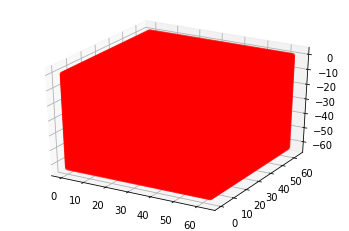

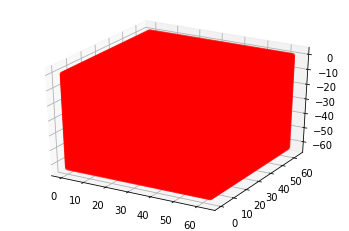

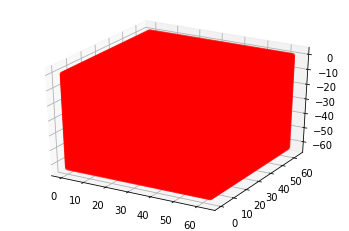

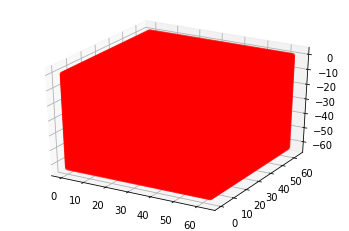

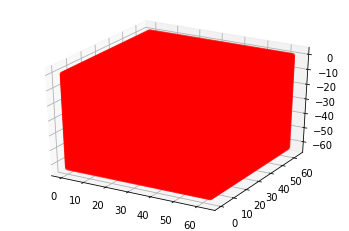

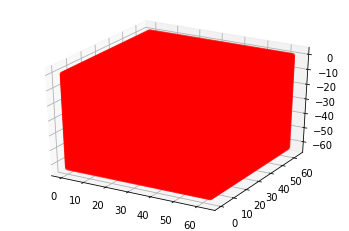

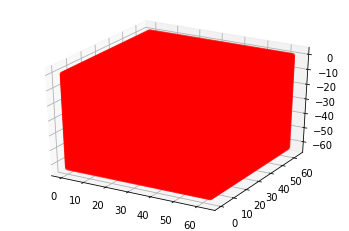

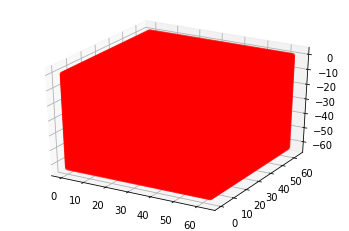

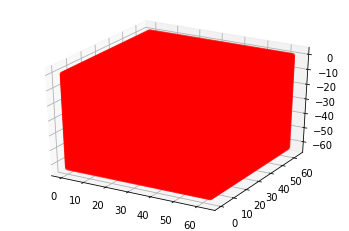

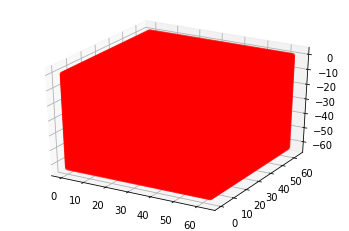

In [19]:
if MODE == 'train':
    print('\n\n####################### STARTING TRAINING #######################\n\n')
    for epoch in range(epochs):
        print(f"\nEpoch: {epoch + 1} out of {len(range(epochs))}")

        gen_losses = []
        dis_losses = []

        number_of_batches = int(volumes.shape[0] / batch_size)
        for index in range(number_of_batches):
            print(f"\tBatch: {index + 1} out of {len(range(number_of_batches))}\n")

            z_sample = np.random.normal(0, 0.33, size=[batch_size, 1, 1, 1, z_size]).astype(np.float32)
            volumes_batch = volumes[index * batch_size:(index + 1) * batch_size, :, :, :]

            # Next, generate volumes using the generate network
            gen_volumes = generator.predict_on_batch(z_sample)

            """
            Train the discriminator network
            """
            discriminator.trainable = True
            if index % 2 == 0:
                loss_real = discriminator.train_on_batch(volumes_batch, labels_real)
                loss_fake = discriminator.train_on_batch(gen_volumes, labels_fake)

                d_loss = 0.5 * np.add(loss_real, loss_fake)
                print("\td_loss:{}".format(d_loss))

            else:
                d_loss = 0.0

            discriminator.trainable = False
            """
            Train the generator network
            """
            z = np.random.normal(0, 0.33, size=[batch_size, 1, 1, 1, z_size]).astype(np.float32)
            g_loss = adversarial_model.train_on_batch(z, labels_real)
            print("\tg_loss:{}".format(g_loss))

            gen_losses.append(g_loss)
            dis_losses.append(d_loss)

            # Every 10th mini-batch, generate volumes and save them
            if index % 10 == 0:
                z_sample2 = np.random.normal(0, 0.33, size=[batch_size, 1, 1, 1, z_size]).astype(np.float32)
                generated_volumes = generator.predict(z_sample2, verbose=3)
                for i, generated_volume in enumerate(generated_volumes[:5]):
                    voxels = np.squeeze(generated_volume)
                    voxels[voxels < 0.5] = 0.
                    voxels[voxels >= 0.5] = 1.
                    saveFromVoxels(voxels, "results/img_{}_{}_{}".format(epoch, index, i))

        # Write losses to Tensorboard
        write_log(tensorboard, 'g_loss', np.mean(gen_losses), epoch)
        write_log(tensorboard, 'd_loss', np.mean(dis_losses), epoch)

    """
    Save models
    """
    generator.save_weights(os.path.join("models", "generator_weights.h5"))
    discriminator.save_weights(os.path.join("models", "discriminator_weights.h5"))

Execute this code when running in Predict Mode

In [20]:
if MODE == 'predict':
    print('\n\n####################### STARTING PREDICTIONS #######################\n\n')

    # Create models
    generator = build_generator()
    discriminator = build_discriminator()

    # Load model weights
    generator.load_weights(os.path.join("models", "generator_weights.h5"), True)
    discriminator.load_weights(os.path.join("models", "discriminator_weights.h5"), True)

    # Generate 3D models
    z_sample = np.random.normal(0, 1, size=[batch_size, 1, 1, 1, z_size]).astype(np.float32)
    generated_volumes = generator.predict(z_sample, verbose=3)

    for i, generated_volume in enumerate(generated_volumes[:2]):
        voxels = np.squeeze(generated_volume)
        voxels[voxels < 0.5] = 0.
        voxels[voxels >= 0.5] = 1.
        saveFromVoxels(voxels, "results/gen_{}".format(i))

Showing Tensorboard

In [21]:
# %tensorboard --logdir logs/